# Homework 1 Part (b) Simulation

In [220]:
import random
# from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
from math import log, floor
from functools import reduce
from time import sleep
from collections import defaultdict
from enum import Enum

In [221]:
class TSType(Enum):
    TERM_TC = 1
    TERM_MIS = 2
    CONFLICT = 3


class TS():
    def __init__(self, sender, sig):
        self.sender = sender
        self.sig = sig


class Msg():
    def __init__(self, sender, body):
        self.sender = sender
        self.body = body
        
    def __str__(self):
        return f'From {self.sender}: {self.body}'

In [222]:
class Sim:
    # Simulates the algorithm for unknown M
    
    def __init__(self, N=None, M=None, ring=None):
        if N: self.N = N
        self.finished = False
        self.valid = True
        
        if not ring:
            self.ring = [-1] * N
            for i in range(N):
                l_nbr, r_nbr = self.ring[(i-1)%N], self.ring[(i+1)%N]
                val = random.randint(0, M)
                while val in [l_nbr, r_nbr]:
                    val = random.randint(0, M)
                self.ring[i] = val
        else:
            self.ring = ring
            self.N = len(ring)
            
        self.term = [False] * self.N
        self.inbufs = [[] for _ in range(self.N)]
        self.vars = [{} for _ in range(self.N)]
        
        # Initialize local variables
        for i in range(self.N):
            self.vars[i]['ci'] = self.ring[i]
            self.vars[i]['cL'] = self.ring[(i-1)%self.N]
            self.vars[i]['cR'] = self.ring[(i+1)%self.N]
            self.vars[i]['Ti'] = False
            self.vars[i]['TTC'] = False
            self.vars[i]['TTCL'] = False
            self.vars[i]['TTCR'] = False
            self.vars[i]['TMIS'] = False
            self.vars[i]['TMISL'] = False
            self.vars[i]['TMISR'] = False
            self.vars[i]['Pi'] = -1
            self.vars[i]['PL'] = -1
            self.vars[i]['PR'] = -1
            self.vars[i]['Ai'] = ''
            self.vars[i]['AL'] = ''
            self.vars[i]['AR'] = ''
            self.vars[i]['piL'] = (i-1)%self.N
            self.vars[i]['piR'] = (i+1)%self.N
        
        self.generators = [None] * self.N
        for i in range(self.N):
            self.generators[i] = self.compute_node(i)
        self.rounds = 0
    
    
    def verify_color(self):
        for i in range(self.N):
            Li, Ri = self.ring[(i-1)%self.N], self.ring[(i+1)%self.N]
            ci = self.ring[i]
            if Li == ci or Ri == ci:
                self.valid = False
                return False
        
        self.valid = True
        return True
    
    
    def verify_MIS(self):
        for i in range(self.N):
            Li, Ri = self.ring[(i-1)%self.N], self.ring[(i+1)%self.N]
            ci = self.ring[i]
            if 0 not in {ci, Li, Ri}:
                self.valid = False
                return False
        
        self.valid = True
        return True
    
    
    def print_ring(self):
        suffix = ''
        if self.finished:
            suffix += ' (FINISHED)'
        if not self.valid:
            suffix += ' (INVALID!)'
        print(f'{self.ring}{suffix}')
    
    
    def rnd(self, verbose=False, steps=8):
        for rep in range(steps):
#             for g, term in zip(self.generators, self.term):
            for i in range(len(self.term)):
                if not self.term[i]: 
#                     print('Node', i, self.term[i])
#                     next(self.generators[i], None)
                    next(self.generators[i])
        
        self.rounds += 4
        self.verify_color()
        self.finished = reduce(lambda x,y : x and y, self.term, True)
        if verbose:
            self.print_ring()
        
    
    def getv(self, i, var):
        return self.vars[i][var]
    
    
    def setv(self, i, var, val):
        self.vars[i][var] = val
    
    
    def compute_node(self, i):
        comp = self.three_colour(i)
        for s in range(8):
            next(comp)
            yield
        
        while self.getv(i, 'Ti') == False:
            if self.getv(i, 'ci') > 2:
#                 print('Node', i, 'running 3 colour')
                comp = self.three_colour(i)
                for s in range(8):
                    next(comp)
                    yield
            elif self.getv(i, 'TTCL') == False or self.getv(i, 'TTCR') == False:
#                 print('Node', i, 'waiting TC')
                comp = self.wait(i, 'TC')
                for s in range(8):
                    next(comp)
                    yield
            elif self.getv(i, 'TMIS') == False:
#                 print('Node', i, 'running MIS stage 1')
                comp = self.mis_stage(i, 1)
                for s in range(8):
                    next(comp)
                    yield
            elif self.getv(i, 'TMISL') == False or self.getv(i, 'TMISR') == False:
#                 print('Node', i, 'waiting TMIS')
                comp = self.wait(i, 'TMIS')
                for s in range(8):
                    next(comp)
                    yield
            else:
#                 print('Node', i, 'running MIS stage 2')
                comp = self.mis_stage(i, 2)
                for s in range(8):
                    next(comp)
                    yield
#                 print('Node', i, 'out')
    
    
    def three_colour(self, i):
        for t in self.inbufs[i]:
            if t.sender == self.getv(i, 'piL') and t.sig == TSType.TERM_TC:
                self.setv(i, 'TTCL', True)
            if t.sender == self.getv(i, 'piR') and t.sig == TSType.TERM_TC:
                self.setv(i, 'TTCR', True)
        self.inbufs[i].clear()
        yield

        self.inbufs[self.getv(i, 'piL')].append(Msg(i, self.getv(i, 'ci')))
        self.inbufs[self.getv(i, 'piR')].append(Msg(i, self.getv(i, 'ci')))
        yield
#             if i == 0:
#                 for m in self.inbufs[i]:
#                     print(m)
        for m in self.inbufs[i]:
            if m.sender == self.getv(i, 'piL'):
                self.setv(i, 'cL', int(m.body))
            if m.sender == self.getv(i, 'piR'):
                self.setv(i, 'cR', int(m.body))
        self.inbufs[i].clear()
        yield

#             print('Node', i, f'ci:{self.getv(i, "ci")}', f'cL:{self.getv(i, "cL")}', f'cR:{self.getv(i, "cR")}')

        for var, cc in zip(['Ai', 'AL', 'AR'], ['ci', 'cL', 'cR']):
            self.setv(i, var, Sim.getAction(self.getv(i, cc)))

        if self.getv(i, 'Ai') == 'LM' and 'BIT' in {self.getv(i, 'AL'), self.getv(i, 'AR')}:
            self.setv(i, 'Ai', 'HOLD')

        if self.getv(i, 'Ai') == 'HOLD':
            self.setv(i, 'Pi', self.getv(i, 'ci'))
        elif self.getv(i, 'Ai') == 'LM':
            if self.getv(i, 'ci') > max(self.getv(i, 'cL'), self.getv(i, 'cR')):
                self.setv(i, 'Pi', min({0, 1, 2}.difference({self.getv(i, 'cL'), self.getv(i, 'cR')})))
            else:
                self.setv(i, 'Pi', self.getv(i, 'ci'))
        else:
            if self.getv(i, 'AL') in {'HOLD', 'LM'} and self.getv(i, 'AR') == {'HOLD', 'LM'}:  # changed here
                self.setv(i, 'Pi', min({0, 1, 2}.difference({self.getv(i, 'cL'), self.getv(i, 'cR')})))
            else:
                d = 0
                ci = self.getv(i, 'ci')
                Ri = self.getv(i, 'cR')
#                     print('Node', i, ci, Ri)
                while (ci&(1<<d)) == (Ri&(1<<d)):
                    d += 1
                self.setv(i, 'Pi', 2*d + ((ci&(1<<d))>>d))

        self.inbufs[self.getv(i, 'piL')].append(Msg(i, self.getv(i, 'Pi')))
        self.inbufs[self.getv(i, 'piR')].append(Msg(i, self.getv(i, 'Pi')))
        yield

        self.setv(i, 'PL', self.getv(i, 'cL'))
        self.setv(i, 'PR', self.getv(i, 'cR'))
        for m in self.inbufs[i]:
            if m.sender == self.getv(i, 'piL'):
                self.setv(i, 'PL', int(m.body))
            if m.sender == self.getv(i, 'piR'):
                self.setv(i, 'PR', int(m.body))
        self.inbufs[i].clear()
        yield

        confL, confR = False, False
        if self.getv(i, 'Ai') == 'BIT':
            confL = self.getv(i, 'Pi') == self.getv(i, 'PL')
            confR = self.getv(i, 'Pi') == self.getv(i, 'PR')
        if confL and confR:
            self.setv(i, 'Pi', min({0, 1, 2}.difference({self.getv(i, 'PL'), self.getv(i, 'PR')})))
            confL, confR = False, False
        elif not confL and not confR:
            pass
        elif confL:
            self.inbufs[self.getv(i, 'piR')].append(Msg(i, 'CONFLICT'))
        else:
            self.inbufs[self.getv(i, 'piL')].append(Msg(i, 'CONFLICT'))
        yield

        neighborConf = False
        if confL or confR:
            if len(self.inbufs[i]):
                neighborConf = True
        self.inbufs[i].clear()
        yield

        if neighborConf:
#                 print('neighborConf')
            if confR:
                self.setv(i, 'Pi', self.getv(i, 'PL'))
            else:
                self.setv(i, 'Pi', self.getv(i, 'PR'))
        elif (confL or confR):
            self.setv(i, 'Pi', min({0, 1, 2}.difference({self.getv(i, 'PL'), self.getv(i, 'PR')})))
        else:
            pass  # No fix


#             if self.getv(i, 'Ai') == 'BIT' and self.getv(i, 'Pi') in {self.getv(i, 'PL'), self.getv(i, 'PR')}:
# #                 print('Correcting node', i, self.getv(i, 'Pi'), '->', end=' ')
#                 self.setv(i, 'Pi', min({0, 1, 2}.difference({self.getv(i, 'PL'), self.getv(i, 'PR')})))
# #                 print(self.getv(i, 'Pi'))
        self.setv(i, 'ci', self.getv(i, 'Pi'))
        self.ring[i] = self.getv(i, 'ci')
        
        if self.getv(i, 'ci') <= 2:
            self.inbufs[self.getv(i, 'piL')].append(TS(i, TSType.TERM_TC))
            self.inbufs[self.getv(i, 'piR')].append(TS(i, TSType.TERM_TC))
            self.setv(i, 'TTC', True)
        yield
            
    
    def mis_stage(self, i, s):
        self.inbufs[i].clear()
        yield
        
        self.inbufs[self.getv(i, 'piL')].append(Msg(i, self.getv(i, 'ci')))
        self.inbufs[self.getv(i, 'piR')].append(Msg(i, self.getv(i, 'ci')))
        yield
        
        for m in self.inbufs[i]:
            if m.sender == self.getv(i, 'piL'):
                self.setv(i, 'cL', int(m.body))
            if m.sender == self.getv(i, 'piR'):
                self.setv(i, 'cR', int(m.body))
        self.inbufs[i].clear()
        yield
        
        if self.getv(i, 'ci') == 0:
            pass
        elif s == 1 and self.getv(i, 'ci') == 1 and 0 not in {self.getv(i, 'cL'), self.getv(i, 'cR')}:
            self.setv(i, 'ci', 0)
            self.ring[i] = 0
        elif s == 2 and self.getv(i, 'ci') == 2 and 0 not in {self.getv(i, 'cL'), self.getv(i, 'cR')}:
            self.setv(i, 'ci', 0)
            self.ring[i] = 0
        
        yield
        
        self.inbufs[i].clear()
        yield
        
        yield
        
        self.inbufs[i].clear()
        yield
        
        if s == 1:
            self.inbufs[self.getv(i, 'piL')].append(TS(i, TSType.TERM_MIS))
            self.inbufs[self.getv(i, 'piR')].append(TS(i, TSType.TERM_MIS))
            self.setv(i, 'TMIS', True)
        else:
            self.setv(i, 'Ti', True)
            self.term[i] = True
        yield
        
    
    def wait(self, i, tt):
        for t in self.inbufs[i]:
            if t.sender == self.getv(i, 'piL'):
                if t.sig == TSType.TERM_TC:
                    self.setv(i, 'TTCL', True)
                elif t.sig == TSType.TERM_MIS:
                    self.setv(i, 'TMISL', True)
            if t.sender == self.getv(i, 'piR'):
                if t.sig == TSType.TERM_TC:
                    self.setv(i, 'TTCR', True)
                elif t.sig == TSType.TERM_MIS:
                    self.setv(i, 'TMISR', True)
        self.inbufs[i].clear()
        yield
        
        self.inbufs[self.getv(i, 'piL')].append(Msg(i, self.getv(i, 'ci')))
        self.inbufs[self.getv(i, 'piR')].append(Msg(i, self.getv(i, 'ci')))
        yield
        
        for m in self.inbufs[i]:
            if m.sender == self.getv(i, 'piL'):
                self.setv(i, 'cL', int(m.body))
            if m.sender == self.getv(i, 'piR'):
                self.setv(i, 'cR', int(m.body))
        self.inbufs[i].clear()
        yield
        
        yield
        
        self.inbufs[i].clear()
        yield
        
        yield
        
        self.inbufs[i].clear()
        yield
        
        if tt == 'TC':
            sig = TSType.TERM_TC
        else:
            sig = TSType.TERM_MIS
        self.inbufs[self.getv(i, 'piL')].append(TS(i, sig))
        self.inbufs[self.getv(i, 'piR')].append(TS(i, sig))
        yield
    
    
    def getAction(c):
        if c <= 2:
            return 'HOLD'
        elif c <= 5:
            return 'LM'
        else:
            return 'BIT'
    
    
    def sim(self, verbose=True):
        if verbose:
            self.print_ring()
        
        while self.valid and not self.finished:
            self.rnd(verbose)
        
        if self.valid:
            self.valid = self.verify_MIS()
        return self.valid

In [234]:
def experiment(M):
    reps = 1000
    ring_size = 100
    rounds = []

    for rep in range(reps):
        sim = Sim(N=ring_size, M=M)
        if not sim.sim(verbose=False):
            print('Failed')
            break
        rounds.append(sim.rounds)
    
    return (np.average(rounds), np.std(rounds))

In [235]:
Ms = [1<<12, 1<<16, 1<<64, 1<<256, 1<<(1<<16)]

data = np.zeros((len(Ms), 2))
for i, M in enumerate(Ms):
    data[i] = experiment(M)

In [236]:
data

array([[32.624     ,  2.11533071],
       [32.608     ,  1.94687853],
       [32.664     ,  2.09549612],
       [32.696     ,  2.07739837],
       [32.74      ,  1.97898964]])

<ErrorbarContainer object of 3 artists>

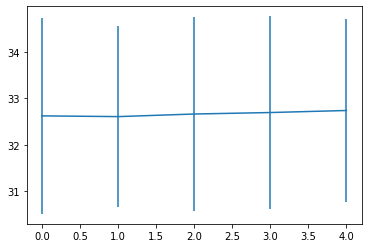

In [249]:
plt.errorbar(x=range(5), y=data[:, 0], yerr=data[:, 1])

## Junk Yard

In [ ]:
sim = Sim(ring=ring.copy())
sim.print_ring()
# print(sim.vars[0])
for _ in range(10):
    sim.rnd(True)
#     for node in [0, -1]:
#         print('Node', node, 'variables:')
#         for i, var in enumerate(['TTC', 'TTCL', 'TTCR', 'TMIS', 'TMISL', 'TMISR', 'Ti']):
#             print(f'\t{var}: {sim.vars[node][var]}', end='')
#             if (i+1) % 3 == 0:
#                 print('')
#         print('')
#     print(sim.vars[0])
#     print(sim.vars[-1])